In [49]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet101
import pandas as pd
import numpy as np

In [50]:
base_dir = './data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# train collection
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation collection
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [51]:
batch_size = 32
img_height = 64
img_width = 64

In [52]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=32
)

validation_ds = keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(64, 64),
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [53]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

In [54]:
# get pretrain model
pre_trained_model = ResNet101(
    input_shape = (img_height, img_width, 3), # 输入大小
    include_top = False, # 不要最后的全连接层
    weights = 'imagenet')

In [55]:
# we don't need to train the pre trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

In [56]:
# train

num_classes = 2

# 为全连接层准备
x = keras.layers.Flatten()(pre_trained_model.output)
# 加入全连接层，这个需要重头训练的
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
# 输出dense层
x = keras.layers.Dense(num_classes, activation='softmax')(x),
# 构建模型序列
model = keras.Model(pre_trained_model.input, x) 

model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['acc'])

In [57]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
)

Epoch 1/20


ValueError: in user code:

    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


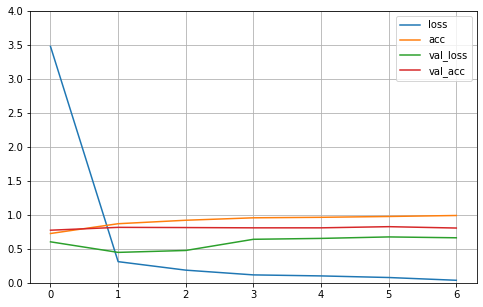

In [47]:
pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True, ylim=(0, 4))

In [48]:
# predict
cat_test_path = './test/cat/cat_test.JPG'
img = keras.preprocessing.image.load_img(
    cat_test_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)


f"This image most likely belongs to {class_names[np.argmax(predictions)]} with a {100 * np.max(predictions)} percent confidence."

'This image most likely belongs to cats with a 85.61770915985107 percent confidence.'